# Mars Entry-Descent-Landing Mission Scenario

This case study demonstrates using Pacti for formalizing a simplified version of a Mars Entry-Descent-Landing mission scenario based on the following paper: [R. Prakash et al. 2008](#ref1)
and the EDL timeline from https://mars.nasa.gov/internal_resources/961/

In [1]:
from pacti.iocontract import *
from pacti.terms.polyhedra import *


https://mars.nasa.gov/mars2020/timeline/landing/entry-descent-landing/

Section: Atmospheric Entry

https://mars.nasa.gov/resources/25445/perseverance-rover-decelerating-in-the-martian-atmosphere-illustration/

In [2]:
AtmosphericEntry = PolyhedralContract.from_string(
    InputVars=[
      "t0",           # entry time
      "v0"            # entry velocity
    ],
    OutputVars=[
      "t1",           # exit time
      "v1"            # exit velocity
    ],
    assumptions=[
      # EDL begings when S/C travels at about 20,000 kph
      "v0 <= 20000"
    ],
    guarantees=[
      # Entry ends 90 seconds after start
      "t0 - t1 <= -90",

      # Exit exit velocity is below 1,600 kph
      "v1 <= 1600"
    ])

print(AtmosphericEntry)

InVars: [t0, v0]
OutVars:[t1, v1]
A: [
  v0 <= 20000.0
]
G: [
  t0 - t1 <= -90.0
  v1 <= 1600.0
]


In [3]:
# plot_guarantees(
#     contract=AtmosphericEntry,
#     x_var=Var("t1"),
#     y_var=Var("v1"),
#     var_values={
#         Var("t0"):0,
#         Var("v0"):20000.0
#     },
#     x_lims=(-10,100),
#     y_lims=(1000, 21000)
# )

In [4]:
print(AtmosphericEntry)

InVars: [t0, v0]
OutVars:[t1, v1]
A: [
  v0 <= 20000.0
]
G: [
  t0 - t1 <= -90.0
  v1 <= 1600.0
]


[  -5. 1005.]


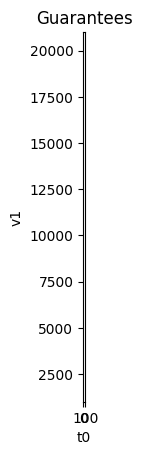

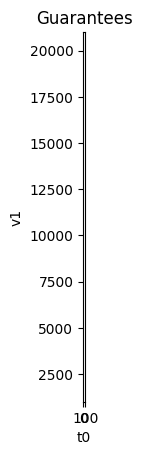

In [5]:
plot_guarantees(
    contract=AtmosphericEntry,
    x_var=Var("t0"),
    y_var=Var("v1"),
    var_values={
        Var("t1"):90,
        Var("v0"):20000.0
    },
    x_lims=(-10,100),
    y_lims=(1000, 21000)
)

## References

<a id="ref1"></a> __[R. Prakash et al. 2008](https://ieeexplore.ieee.org/abstract/document/4526283)__

R. Prakash et al., "Mars Science Laboratory Entry, Descent, and Landing System Overview," 2008 IEEE Aerospace Conference, Big Sky, MT, USA, 2008, pp. 1-18, doi: 10.1109/AERO.2008.4526283.
